# Workflow model validatie

*Deze workflow (voor de model validatie) is momenteel nog in de ontwikkel fase en wordt in de loop van de tijd verder uitgebreid en verbeterd.*  </br>
Laatste aanpassing: 3 juli 2024 </br>
Contact: Petra Hulsman </br>

## Context

Binnen HDSR worden hydraulische modellen gebruikt voor het beantwoorden van verschillende vraagstukken. Bijvoorbeeld: Zitten er knelpunten in het systeem bij een T=1 zomer afvoersituatie? Hoeveel ruimte is er beschikbaar voor NVOs? Tot welke diepte moet minimaal gebaggerd worden? Welke dimensies moeten nieuwe kunstwerken bij voorkeur hebben om knelpunten te kunen voorkomen? Welke gebieden zijn kwetsbaar voor inundatie? Momenteel (anno begin 2024) wordt voornamelijk Sobek gebruikt om debieten en waterniveaus in primaire watergangen te modelleren. Het is van groot belang dat onze modellen betrouwbaar zijn.

In deze notebook is een workflow voor de model validatie opgezet. Deze kan gebruikt worden om de betrouwbaarheid van onze modellen te kunnen bepalen en om model onnauwkeurigheden te kunnen identificeren en verbeteren. Deze evaluatie is sterk afhankelijk van de betrouwbaarheid van geobserveerde data, namelijk veld observaties en satelliet data die hiervoor gebruikt worden. Het is daarom erg belangrijk om te onthouden dat er niet alleen onzekerheden zijn in het model maar ook in de geobserveerde data. Daarom wordt aanbevolen kritisch naar de resultaten te kijken voordat een oordeel getroffen wordt.

## Uitvoer model validatie

Deze code werkt momenteel met de virtuale omgeving "Petra_arcpy" op de rekenserver reken05. Momenteel is een handmatige na-controle aan te raden om te verifieren of alle ruimtelijke koppelingen tussen model en data goed is gegaan.

### 1. RUPROF model (T=1, zomer afvoersituatie)

#### Streefpeil
<br>
<u>Variabele</u>:  <br>
- Zomer streepeil  <br>
<u>Aanpak</u>:  <br>
- Verschil tussen 1) streefpeil (BR), en 2) startwaarde gemodelleerd waterniveau (RUPROF) <br>
<u>Randvoorwaarden</u>: <br>
- / <br>
<u>Output</u>: <br>
- Shapefile (polypoints): verschil tussen BR en model <br>
- Figuren: verschil per modelknooppunt en maximum verschil per afvoergebied

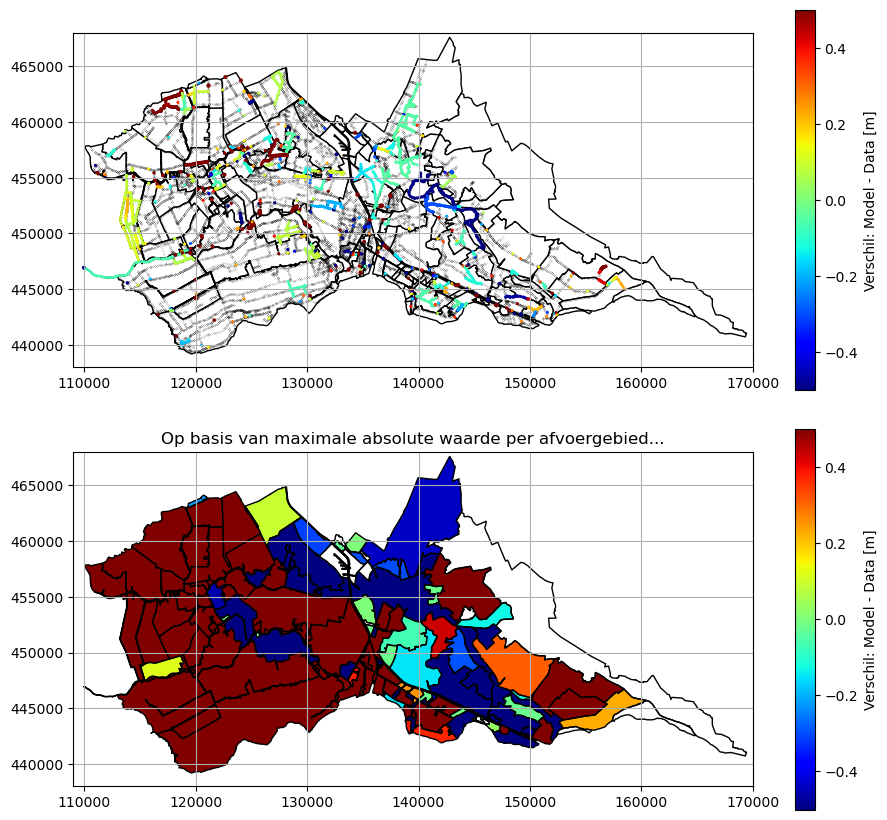

In [1]:
import os
import functies_ruimtelijk_streefpeil
class paths():
    # Input
    root         = os.getcwd()    
    df_WL_csv    = os.path.join(root, 'Input','Sobek output','SOBEK_WL_28122023_init.csv') # gemodelleerd waterniveau op basis van Sobek (op t=0 uit RUPROF)
    shp_peil     = os.path.join(root,"GIS input","BR-VS_Peilgebieden.shp") # shapefile van de peilgebieden
    shp_reach    = os.path.join(root,"GIS input","RchSegments.shp") # shapefile van de reach segments (watergangen), export uit Sobek
    shp_node     = os.path.join(root,"GIS input",'3b_nod_joined.shp') # shapefile van de model knopen, export uit Sobek en ge-joined met BR-peilgebieden in ArcMAP
    shp_afvoer   = os.path.join(root,"GIS input","BR_VS_Afvoergebieden.shp") # shapefile van de afvoergebieden
    
    # Output
    shp_node_dWL = os.path.join(root,"GIS output",'WL_streefpeil_RUPROF_data.shp') # shapefile met het waterniveau verschil per knooppunt
    fig          = os.path.join(root,"Output",'fig_WL_streefpeil.png') # figuur met de verschillen in waterniveau
    fightml      = os.path.join(root,"Output",'fig_WL_streefpeil.html') # html figuur met de verschillen in waterniveau

    
functies_ruimtelijk_streefpeil.main(paths)

#### Waterniveau
<br>
<u>Variabele</u>:  <br>
- Waterniveau voor T=1 in de zomer  <br>
<u>Aanpak</u>:  <br>
- Verschil tussen 1) data (FEWS-WIS), en 2) model (RUPROF) <br>
<u>Randvoorwaarden</u>: <br>
- Het meetpunt moet binnen een afstand van 5 m van het model knooppunt zijn. <br>
- Minimaal 3 jaar aan geobserveerde data beschikbaar (niet per se aaneengesloten) voor het berekenen van het T=1 debiet. <br>
<u>Output</u>: <br>
- Shapefile (polypoints): verschil tussen data en model <br>
- Figuren: verschil per observatie punt en maximum verschil per afvoergebied

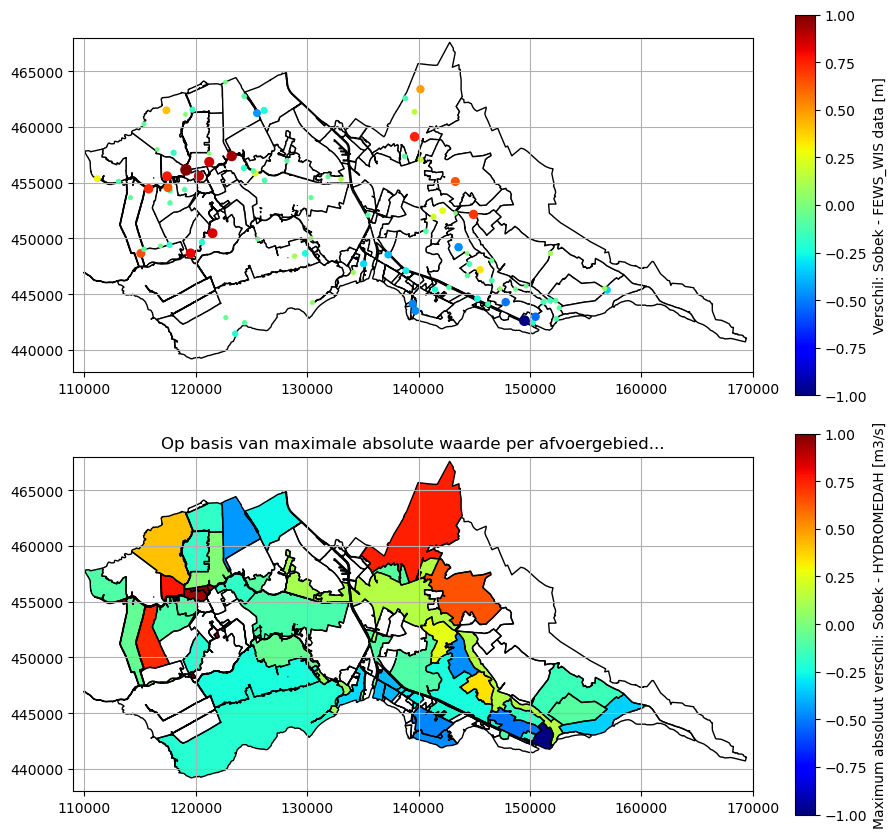

In [2]:
import os
import numpy as np
import functies_punt_WL_T1
class paths():
    # Input data
    root           = os.getcwd()    
    df_WL_WISdata  = os.path.join(root, 'Input','FEWS-WIS','WL_2000_2023.csv') # FEWS-WIS data bij kunstwerken
    df_WL_WISsites = os.path.join(root, 'Input','FEWS-WIS','ow_ws.csv') # FEWS-WIS metadata voor meetpunten
    df_model       = os.path.join(root, 'Input','Sobek output','SOBEK_WL_281223.csv') # gemodelleerd debiet op basis van Sobek (op t=0 uit RUPROF)
    shp_node       = os.path.join(root,"GIS input",'3b_nod_joined.shp') # shapefile van de model knopen, export uit Sobek en ge-joined met BR-peilgebieden in ArcMAP
    shp_afvoer     = os.path.join(root,"GIS input","BR_VS_Afvoergebieden.shp") # shapefile van de afvoergebieden
    shp_insteek   = os.path.join(root,"GIS input","BR-VS_Insteekvlak.shp") # shapefile van het insteekvlak
    shp_afvoer    = os.path.join(root,"GIS input","BR_VS_Afvoergebieden.shp") # shapefile van de afvoergebieden
    
    # Output data
    gdf_data      = os.path.join(root,"GIS output","WL_T1_DATA.shp") # shapefile met de gemeten data (obv FEWS-WIS)
    gdf_model     = os.path.join(root,"GIS output","WL_T1_RUPROF.shp") # shapefile met de Sobek data
    gdf_joined    = os.path.join(root,"GIS output","WL_T1_RUPROF_DATA.shp") # shapefile met gemeten & gemodelleerd waterniveau
    fig           = os.path.join(root,"Output",'fig_WL_T1.png') # figuur met de verschillen in waterniveau
    fightml       = os.path.join(root,"Output",'fig_WL_T1.html') # figuur met de verschillen in waterniveau
    
months = [5,6,7,8,9] # maanden in het jaar om statistiek over te berekenen
years  = np.arange(2000,2023)
functies_punt_WL_T1.main(paths,months,years)

#### Afvoer (laterals)
<br>
<u>Variabele</u>:  <br>
- Afvoer (i.e. lateral) voor T=1 in de zomer  <br>
<u>Aanpak</u>:  <br>
- Verschil tussen 1) hydrologisch/grondwater model (HYDROMEDAH), en 2) karakterestieke waarden per landgebruik (RUPROF input) <br>
<u>Randvoorwaarden</u>: <br>
- / <br>
<u>Output</u>: <br>
- Shapefile (polygons): verschil tussen HYDROMEDAH en RUPROF <br>
- Figuren: verschil per afwateringsgebied

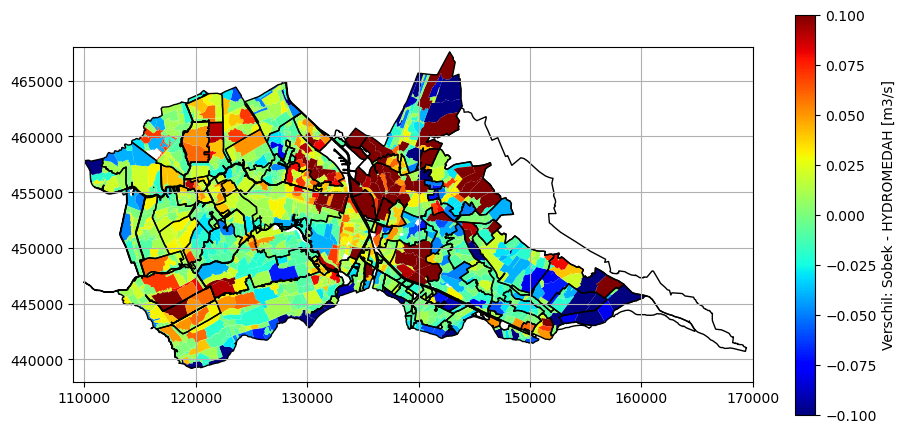

In [3]:
import os
import functies_punt_laterals_T1

class paths():
    # Input bestanden
    root          = os.getcwd()
    shp_RchSeg    = os.path.join(root, 'GIS input','RchSegments.shp') # shapefile van de reach segments, export uit Sobek
    shp_node      = os.path.join(root, 'GIS input','Sbk_Lat_n.shp') # shapefile van de lateralen punten, export uit Sobek
    dat_Sobek     = os.path.join(root, 'Input','Sobek output','MOD_ADJ_V4.lit') # locatie Sobek HIS output bestanden
    dat_lat       = os.path.join(root, 'Input','Sobek output','LATERAL.DAT') # lateralen data, Sobek input data
    shp_afvoer    = os.path.join(root,"GIS input","BR_VS_Afvoergebieden.shp") # shapefile van de afvoergebieden
    shp_afwatr    = os.path.join(root,"GIS input","Afwateringseenheden_2020.shp") # shapefile van de afwateringsgebieden
    
     # Output bestanden
    shp_laterals  = os.path.join(root,"GIS output",'laterals_T1_RUPROF_HYDROMEDAH.shp') # shapefile met lateralen data op basis van HYDROMEDAH, RUPROF en het verschil
    shp_HYDROMEDAH= os.path.join(root,"GIS output",'laterals_T1_HYDROMEDAH.shp') # shapefile met lateralen data op basis van HYDROMEDAH, alleen opgeslagen als er iets mis gaat bij het converteren van reach segments naar lateralen knopen (u wordt geinformeerd als dit gebeurt)
    shp_RUPROF    = os.path.join(root,"GIS output",'laterals_T1_RUPROF.shp') # shapefile met lateralen data op basis van RUPROF
    fig           = os.path.join(root,"Output",'fig_laterals_gem.png') # Figuur van de verschillen in lateralen data
    fightml       = os.path.join(root,"Output",'fig_laterals_gem.html') # Figuur van de verschillen in lateralen data

months = [5,6,7,8,9] # maanden in het jaar om statistiek over te berekenen
years  = np.arange(2010,2022) # zie Sobek continue model time-range
functies_punt_laterals_T1.main(paths,months,years)

#### Debiet
<br>
<u>Variabele</u>:  <br>
- Debiet voor T=1 in de zomer  <br>
<u>Aanpak</u>:  <br>
- Verschil tussen 1) data (FEWS-WIS), en 2) model (RUPROF) <br>
<u>Randvoorwaarden</u>: <br>
- Debiet data bij gemalen en debietmeters (overige kunstwerken zijn momenteel uitgesloten). <br>
- Iedere observatie locatie is apart gebruikt (dus bijv. geen som van pompen). <br>
- Minimaal 3 jaar aan geobserveerde data beschikbaar (niet per se aaneengesloten) voor het berekenen van het T=1 debiet. <br>
<u>Output</u>: <br>
- Shapefile (polypoints): verschil tussen data en model <br>
- Figuren: verschil per observatie punt en maximum verschil per afvoergebied



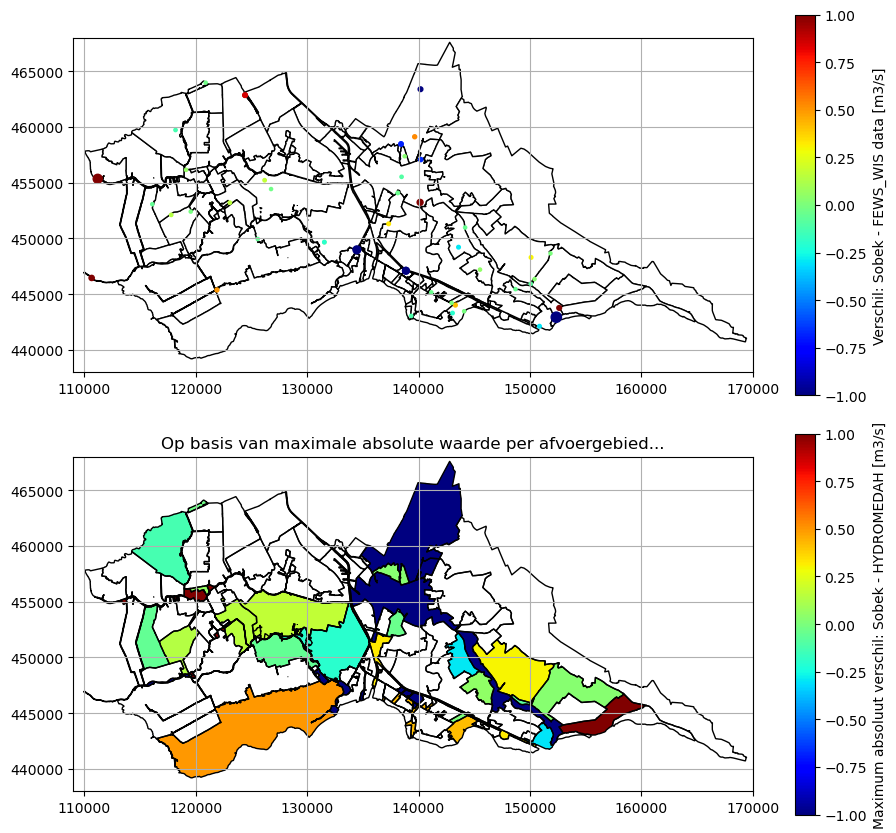

In [4]:
import os
import numpy as np
import functies_punt_Q_T1

class paths():
    # Input data
    root          = os.getcwd()    
    df_Q_model    = os.path.join(root, 'Input','Sobek output','SOBEK_Q_281223.csv') # gemodelleerd debiet op basis van Sobek (op t=0 uit RUPROF)
    # verwijder in df_Q_model de exponent in de eenheid (door m3/s te typen in het csv bestand); de exponent zorgt namelijk voor een foutmelding bij het inlezen van het bestand
    df_Q_WISdata  = os.path.join(root, 'Input','FEWS-WIS','Q_kunstwerken_2000_2023.csv') # FEWS-WIS data bij kunstwerken
    df_Q_WISsites = os.path.join(root, 'Input','FEWS-WIS','ow_sl.csv') # FEWS-WIS metadata voor meetpunten
    shp_peil      = os.path.join(root,"GIS input","BR-VS_Peilgebieden.shp") # shapefile van de peilgebieden
    shp_reach     = os.path.join(root,"GIS input","RchSegments.shp") # shapefile van de reach segments (watergangen), export uit Sobek
    shp_afvoer    = os.path.join(root,"GIS input","BR_VS_Afvoergebieden.shp") # shapefile van de afvoergebieden
    shp_insteek   = os.path.join(root,"GIS input","BR-VS_Insteekvlak.shp") # shapefile van het insteekvlak
    
    # Output data
    gdf_data      = os.path.join(root,"GIS output","Q_T1_DATA.shp") # shapefile met de gemeten debiet data (obv FEWS-WIS)
    gdf_model     = os.path.join(root,"GIS output","Q_T1_RUPROF.shp") # shapefile met de Sobek data
    gdf_joined    = os.path.join(root,"GIS output","Q_T1_RUPROF_DATA.shp") # shapefile met gemeten & gemodelleerd debiet
    fig           = os.path.join(root,"Output",'fig_Q_T1.png') # figuur met de verschillen in debiet
    fightml       = os.path.join(root,"Output",'fig_Q_T1.html') # figuur met de verschillen in debiet


months = [5,6,7,8,9] # maanden in het jaar om statistiek over te berekenen
years  = np.arange(2000,2023)
functies_punt_Q_T1.main(paths, months, years)
    

### 2. Sobek continue model (2010 - 2021)
#### Debiet
<br>
<u>Variabele</u>:  <br>
- Gemiddeld debiet in primaire watergang  <br>
<u>Aanpak</u>:  <br>
- Verschil tussen 1) data (FEWS-WIS), en 2) model (Sobek model) <br>
<u>Randvoorwaarden</u>: <br>
- Validatie over de periode 2019 - 2021 <br>
- Statistieken: verschil gemiddelde waarde  <br>
<u>Output</u>: <br>
- Shapefile (polypoints): verschil tussen data en model gemiddeld over een periode  <br>
- Figuren: verschil per observatie punt en maximum verschil per afvoergebied

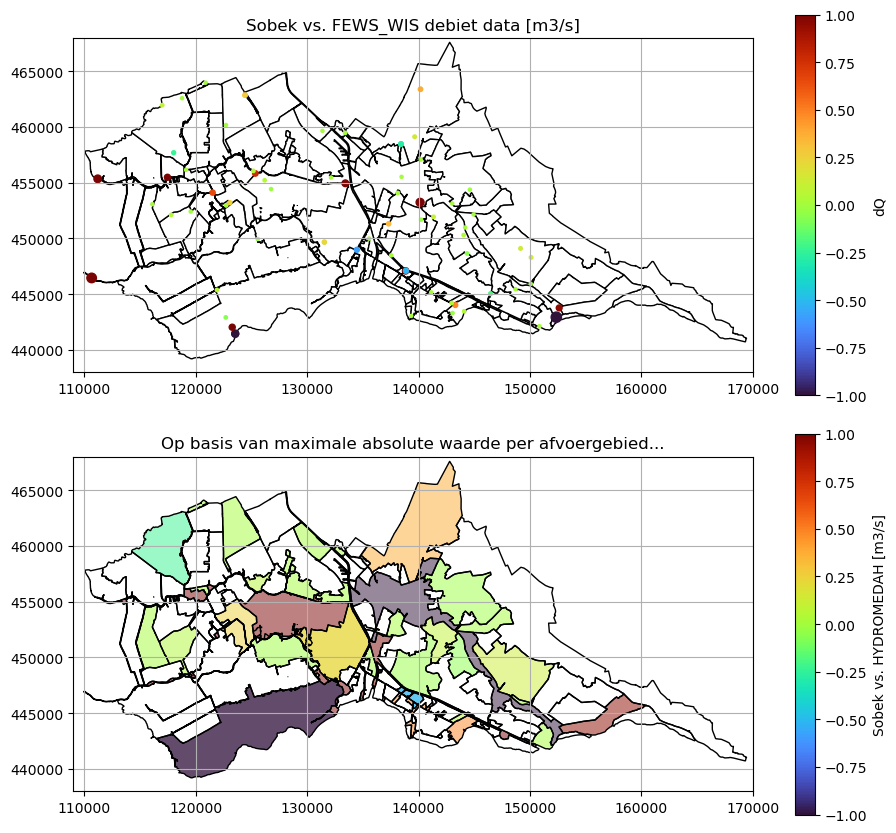

In [5]:
import os
import numpy as np
import functies_punt_Qseries

class paths():
    # Input data
    root          = os.getcwd()    
    data_sobek    = os.path.join(root,"Input","Sobek output","MOD_ADJ_V4.lit") # folder Sobek HIS bestanden
    shp_reach     = os.path.join(root,"GIS input","RchSegments_Qstat.shp") # shapefile van de reach segments (watergangen), export uit Sobek
    shp_afvoer    = os.path.join(root,"GIS input","BR_VS_Afvoergebieden.shp") # shapefile van de afvoergebieden
    df_Q_WISdata  = os.path.join(root, 'Input','FEWS-WIS','Q_hourly_pomp_ADCP_2010_2023.csv') # FEWS-WIS data bij kunstwerken
    df_Q_WISsites = os.path.join(root, 'Input','FEWS-WIS','ow_sl.csv') # FEWS-WIS metadata voor meetpunten
    shp_insteek   = os.path.join(root,"GIS input","BR-VS_Insteekvlak.shp") # shapefile van het insteekvlak
    shp_afvoer    = os.path.join(root,"GIS input","BR_VS_Afvoergebieden.shp") # shapefile van de afvoergebieden
    
    # Output data
    gdf_joined    = os.path.join(root,"GIS output","Q_gem_Sobek_DATA.shp") # shapefile met gemeten & gemodelleerd debiet
    fig           = os.path.join(root,"Output",'fig_Q_gem.png') # figuur met de verschillen in debiet
    fightml       = os.path.join(root,"Output",'fig_Q_gem.html') # figuur met de verschillen in debiet

months        = np.arange(1,13) # maanden in het jaar om statistiek over te berekenen
years         = np.arange(2019,2022) # jaren om statistiek over te berekenen
functies_punt_Qseries.main(paths, months, years)

#### Stroomrichting
<br>
<u>Variabele</u>:  <br>
- Stroomrichting in primaire watergang  <br>
<u>Aanpak</u>:  <br>
- Verschil tussen 1) data (FEWS-WIS), en 2) model (Sobek model) <br>
<u>Randvoorwaarden</u>: <br>
- Validatie over de periode 2010 - 2021 <br>
- Statistieken: (alleen visueel)  <br>
<u>Output</u>: <br>
- Figuren: tijdseries op locaties waar de stroomrichting veranderd

In [6]:
import os
import numpy as np
import functies_punt_Qdir

class paths():
    # Input data
    root          = os.getcwd()    
    data_sobek    = os.path.join(root,"Input","Sobek output","MOD_ADJ_V4.lit") # folder Sobek HIS bestanden
    shp_reach     = os.path.join(root,"GIS input","RchSegments_Qstat.shp") # shapefile van de reach segments (watergangen), export uit Sobek
    shp_afvoer    = os.path.join(root,"GIS input","BR_VS_Afvoergebieden.shp") # shapefile van de afvoergebieden
    df_Q_WISdata  = os.path.join(root, 'Input','FEWS-WIS','Q_hourly_pomp_ADCP_2010_2023.csv') # FEWS-WIS data bij kunstwerken
    df_Q_WISsites = os.path.join(root, 'Input','FEWS-WIS','ow_sl.csv') # FEWS-WIS metadata voor meetpunten
    shp_insteek   = os.path.join(root,"GIS input","BR-VS_Insteekvlak.shp") # shapefile van het insteekvlak
    shp_afvoer    = os.path.join(root,"GIS input","BR_VS_Afvoergebieden.shp") # shapefile van de afvoergebieden
    
    # Output data
    fightml       = os.path.join(root,"Output",'fig_Q_dir.html') # figuur met de debieten op locaties waar de stroomrichting veranderd

months        = np.arange(1,13) # maanden in het jaar om statistiek over te berekenen
years         = np.arange(2010,2022) # jaren om statistiek over te berekenen
functies_punt_Qdir.main(paths, months, years)

#### Afvoer (laterals)
<br>
<u>Variabele</u>:  <br>
- Gemiddelde afvoer (i.e. lateral) richting primaire watergang  <br>
<u>Aanpak</u>:  <br>
- Verschil tussen 1) satelliet data (FEWS_WIS), en 2) model (HYDROMEDAH, via laterals in Sobek model) <br>
<u>Randvoorwaarden</u>: <br>
- Gemiddelde afvoer per peilgebied <br>
<u>Output</u>: <br>
- Shapefile (polygons): verschil tussen data en model <br>
- Figuren: verschil per afwateringsgebied

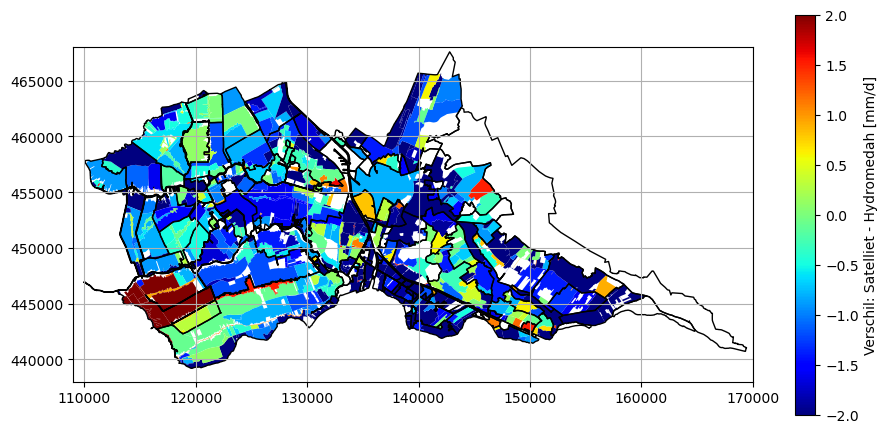

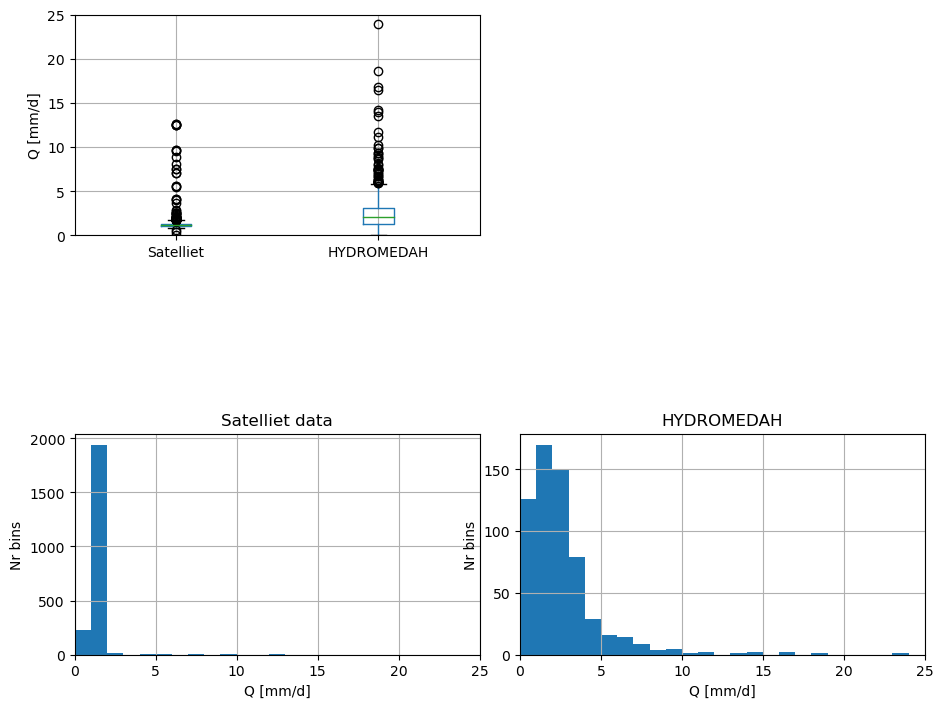

In [7]:
import os
import numpy as np
import functies_ruimtelijk_afvoer_gem

class paths():
    # Input bestanden
    root          = os.getcwd()
    shp_RchSeg    = os.path.join(root, 'GIS input','RchSegments.shp') # shapefile van de reach segments, export uit Sobek
    shp_node      = os.path.join(root, 'GIS input','Sbk_Lat_n.shp') # shapefile van de lateralen punten, export uit Sobek
    dat_Sobek     = os.path.join(root, 'Input','Sobek output','MOD_ADJ_V4.lit') # locatie Sobek HIS output bestanden
    dat_lat       = os.path.join(root, 'Input','Sobek output','LATERAL.DAT') # lateralen data, Sobek input data
    shp_afvoer    = os.path.join(root,"GIS input","BR_VS_Afvoergebieden.shp") # shapefile van de afvoergebieden
    shp_afwatr    = os.path.join(root,"GIS input","Afwateringseenheden_2020.shp") # shapefile van de afwateringsgebieden
    shp_peil      = os.path.join(root,"GIS input","BR-VS_Peilgebieden_clip.shp") # shapefile van de peilgebieden
    df_P          = os.path.join(root,'Input','FEWS-WIS','P_KNMI_2000_2024_peilgebieden.csv') # regen data o.b.v. remote sensing
    df_E          = os.path.join(root,'Input','FEWS-WIS','E_ELEAF_2000_2024_peilgebieden.csv') # verdamping data o.b.v. remote sensing
    
    # temp bestanden
    shp_temp = os.path.join(root,'GIS input','BR_VS_peilgebieden_2024_gem_data.shp') # gem remote sensing data voor de huidige peilgebieden (handmiatig in GIS gemaakt); tijdelijk gemaakt ivm mismatch tussen BR en WIS in de peilgebieden
    
    # Output bestanden
    shp_comp       = os.path.join(root,"GIS output",'laterals_RS_gem_HYDROMEDAH_data.shp') # shapefile met afvoer data op basis van HYDROMEDAH, satelliet data en het verschil
    shp_sat        = os.path.join(root,"GIS output",'laterals_RS_gem_SATELLIET.shp') # shapefile met afvoer data op basis van satelliet data
    shp_HYDROMEDAH = os.path.join(root,"GIS output",'laterals_RS_gem_HYDROMEDAH.shp') # shapefile met afvoer data op basis van HYDROMEDAH
    fig           = os.path.join(root,"Output",'fig_laterals_sat_gem.png') # Figuur van de verschillen in afvoer
    fightml       = os.path.join(root,"Output",'fig_laterals_sat_gem.html') # Figuur van de verschillen in afvoer
    

months = [5,6,7,8,9] # maanden in het jaar om statistiek over te berekenen
years  = np.arange(2010,2022) # zie Sobek continue model time-range
functies_ruimtelijk_afvoer_gem.main(paths,months,years)